# Exercise 04 ANN for Regression - Assignment - Solution

<span style="color:red">**The submission deadline of this assignment is 09/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained ANN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a regression model using ANN.

The problem to be solved is predicting the price of houses in California.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a non-linear multi-layer ANN
- Train the ANN
- Save and load the trained model
- Make predictions and evaluation

### Import libraries

In [1]:
# [TBC] complete your code here with proper comments
# import the necessary libraries
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# [TBC] complete your code here with proper comments
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

<span style="color:red">**[TBC]**</span> You need to:
- Use `sklearn.datasets.fetch_california_housing()` to load California Housing dataset
- Pre-process the dataset
    - Scale numerical features with [min-max scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Divide the dataset into the training and test set
- Create `TensorDataset` instances to store the dataset
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# [TBC] complete your code here with proper comments
# load the dataset
feature, label = datasets.fetch_california_housing(
    return_X_y = True,
    as_frame = False, # get data as numpy array
)

In [4]:
# [TBC] complete your code here with proper comments
# scale numerical features with MinMaxScaler
scaler = MinMaxScaler()
scaled_feature = scaler.fit_transform(feature)

In [5]:
# [TBC] complete your code here with proper comments
# train test split
train_feature, test_feature, train_label, test_label = train_test_split(
    scaled_feature,
    label,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

In [6]:
# [TBC] complete your code here with proper comments
# specify the type of data stored in the tensors to avoid incompatiblity
train_ds = TensorDataset(
    torch.tensor(train_feature, dtype = torch.float32),
    torch.tensor(train_label, dtype = torch.float32)
)
test_ds = TensorDataset(
    torch.tensor(test_feature, dtype = torch.float32),
    torch.tensor(test_label, dtype = torch.float32)
)

In [7]:
# [TBC] complete your code here with proper comments
# create the train and test data loaders
batch_size = 4096
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

## Task 2. Create a non-linear multi-layer ANN

<span style="color:red">**[TBC]**</span> You need to:
- Create a custom class to define the structure of the network
- Create an instance of this class as the ANN

In [8]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, n_labels)
        )
    def forward(self, X):
        return self.net(X)

In [9]:
# [TBC] complete your code here with proper comments
# create the neural network
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)

In [10]:
# [TBC] complete your code here with proper comments
# print network structure and learning parameters
print(f"Model structure:\n{model}\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Model structure:
NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

Layer: net.0.weight | Size: torch.Size([128, 8])
Layer: net.0.bias | Size: torch.Size([128])
Layer: net.2.weight | Size: torch.Size([32, 128])
Layer: net.2.bias | Size: torch.Size([32])
Layer: net.4.weight | Size: torch.Size([8, 32])
Layer: net.4.bias | Size: torch.Size([8])
Layer: net.6.weight | Size: torch.Size([1, 8])
Layer: net.6.bias | Size: torch.Size([1])


## Task 3. Train the ANN

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
- Specify traing hyper-parameters:
    - the loss function
    - the optimizer
    - the learning rate
    - the number of epoches to train
- Train the ANN
    - Adjust the training hyper-parameters if necessary to get a good result
- Plot the loss history of the training process

In [11]:
# [TBC] complete your code here with proper comments
# define the training function
def train(dataloader, model, loss_fn, optimizer, epochs):
    batch_loss_history = [] # for recording the average loss of a batch
    epoch_loss_history = [] # for recording the average loss of an epoch
    model.train() # set the model in training mode
    for epoch in range(epochs): # iterate pre-defined number of epoches
        epoch_loss = 0.0 # initial epoch loss is set to zero
        for (X, y) in dataloader: # get a batch of training samples
            pred = model(X).squeeze() # make predictions, squeeze() reduce `pred` to 1D tensor
            batch_loss = loss_fn(pred, y) # compute the current batch loss
            batch_loss.backward() # compute gradients by backpropagation
            optimizer.step() # update learning parameters according to gradients
            optimizer.zero_grad() # reset the gradients to zero
            batch_loss_history.append(batch_loss.item()) # record current batch loss
            epoch_loss += batch_loss.item() # accumulate batch losses for compute epoch loss
        epoch_loss /= len(dataloader) # compute current epoch loss
        epoch_loss_history.append(epoch_loss) # record current epoch loss
        print(f"Epoch {epoch + 1}: train loss = {epoch_loss}") # print log
    return batch_loss_history, epoch_loss_history

In [12]:
# [TBC] complete your code here with proper comments
# define the training hyper-parameters
loss_fn = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
epochs = 1000

In [13]:
# [TBC] complete your code here with proper comments
# train the neural network
batch_loss_history, epoch_loss_history = train(train_dl, model, loss_fn, optimizer, epochs)

Epoch 1: train loss = 4.890956997871399
Epoch 2: train loss = 4.2625426054000854
Epoch 3: train loss = 3.7214027643203735
Epoch 4: train loss = 3.2666447162628174
Epoch 5: train loss = 2.898656666278839
Epoch 6: train loss = 2.567238211631775
Epoch 7: train loss = 2.3141015768051147
Epoch 8: train loss = 2.0567529797554016
Epoch 9: train loss = 1.8583855628967285
Epoch 10: train loss = 1.6995921730995178
Epoch 11: train loss = 1.5637767314910889
Epoch 12: train loss = 1.4763479828834534
Epoch 13: train loss = 1.4201705157756805
Epoch 14: train loss = 1.378383457660675
Epoch 15: train loss = 1.3548741340637207
Epoch 16: train loss = 1.336105763912201
Epoch 17: train loss = 1.3309260308742523
Epoch 18: train loss = 1.3260159492492676
Epoch 19: train loss = 1.3125036656856537
Epoch 20: train loss = 1.323371946811676
Epoch 21: train loss = 1.3181126713752747
Epoch 22: train loss = 1.3155758380889893
Epoch 23: train loss = 1.3147167563438416
Epoch 24: train loss = 1.3039326965808868
Epoch 2

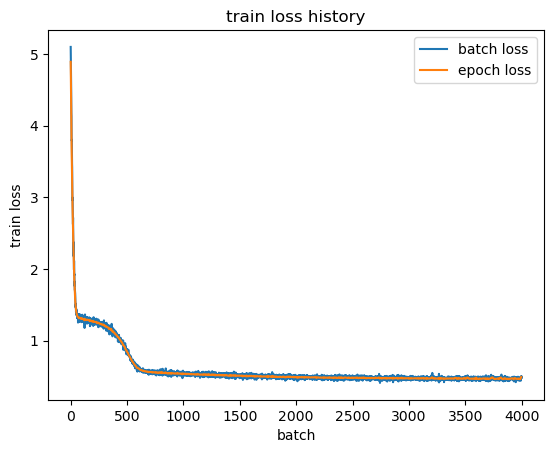

In [14]:
# [TBC] complete your code here with proper comments
# plot the train loss history
plt.figure()
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = (int(len(train_feature) / batch_size + 1))
plt.plot(batch, batch_loss_history, '-', label = 'batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, '-', label = 'epoch loss')
plt.title('train loss history')
plt.xlabel('batch')
plt.ylabel('train loss')
plt.legend()
plt.show()

## Task 4. Save and load the trained model

<span style="color:red">**[TBC]**</span> You need to:
- Save the trained model
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Re-create the neural network and load the saved model

In [15]:
# [TBC] complete your code here with proper comments
# save model
file_name = 'assignment_model.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to '+ file_name)

Saved PyTorch Model State to assignment_model.pth


In [16]:
# [TBC] complete your code here with proper comments
model = NeuralNetwork(
    n_features = feature.shape[1],
    n_labels = 1
)
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

## Task 5. Make predictions and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
- Make predictions on the test dataset
- Evaluate the performance
    - Compute RMSE and print it
    - Compute &R^2& score and print it
- Plot the predictions vs. target values

In [17]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_pred_list = [] # for recording batch predictions
    model.eval() # set the model in evaluation mode
    with torch.no_grad(): # disable automatic gradient computing
        loss = 0.0 # set initial test loss to zero
        for (X, y) in dataloader: # get a batch from test samples
            batch_pred = model(X).squeeze() # make predictions, squeeze() reduce `batch_pred` to 1D tensor
            batch_loss = loss_fn(batch_pred, y) # compute current batch loss
            loss += batch_loss.item() # accumulate batch losses for compute test loss
            batch_pred_list.append(batch_pred) # record predictions on current batch
        loss /= len(dataloader) # compute test loss
        pred = np.concatenate(batch_pred_list) # reform the predictions as a numpy 1D array
        print(f"test loss = {loss}") # print log
    return pred, loss

In [18]:
# [TBC] complete your code here with proper comments
# make prediction on test set and evaluate the performance
test_pred, test_loss = test(test_dl, model, loss_fn)
# model performance on the testing dataset
rmse_test = mean_squared_error(test_label, test_pred, squared = False)
r2_test = r2_score(test_label, test_pred)
# print RMSE and r2 score
print("RMSE test:", rmse_test)
print("R2 test:", r2_test)

test loss = 0.5259385406970978
RMSE test: 0.7222069830762834
R2 test: 0.6088417132642664


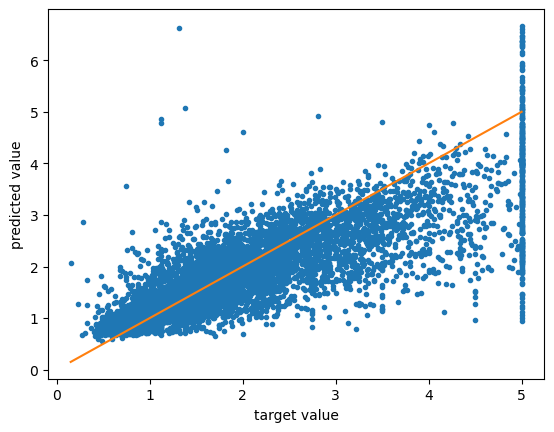

In [19]:
# [TBC] complete your code here with proper comments
# plot the prediction results of the test dataset
plt.figure()
plt.plot(test_label, test_pred, '.')
plt.plot([min(test_label), max(test_label)], [min(test_label), max(test_label)], '-')
plt.xlabel('target value')
plt.ylabel('predicted value')
plt.show()